In [189]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [190]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df_dmc = read_excel('../../Data/Processed data/lstm_dmc.xlsx')
df_square = read_excel('../../Data/Processed data/Square.xlsx')
df_popular = read_excel('../../Data/Processed data/popular medical.xlsx')
df_shomorita = read_excel('../../Data/Processed data/shomorita.xlsx')
df_anowarKhan = read_excel('../../Data/Processed data/Anowar Khan.xlsx')

In [191]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].values.astype(float)
    #sort by date
    df = df.sort_values(by='Date')
    # for rows where df['Affected'] is null or non-numeric, replace with 0
    df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

In [192]:
df_dmc = preprocess(df_dmc)
df_square = preprocess(df_square)
df_popular = preprocess(df_popular)
df_shomorita = preprocess(df_shomorita)
df_anowarKhan = preprocess(df_anowarKhan)

In [193]:
dfs = [df_dmc, df_square, df_popular, df_shomorita, df_anowarKhan]

In [194]:
# add four columns for four hospitals
df_dmc['alpha_square'] = 0
df_dmc['alpha_popular'] = 0
df_dmc['alpha_shomorita'] = 0
df_dmc['alpha_anowarKhan'] = 0

In [195]:
df_dmc.head()

,Date,Affected,alpha_square,alpha_popular,alpha_shomorita,alpha_anowarKhan
0,1.567296e+18,92.0,0,0,0,0
1,1.567382e+18,82.0,0,0,0,0
2,1.567469e+18,64.0,0,0,0,0
3,1.567555e+18,47.0,0,0,0,0
4,1.567642e+18,63.0,0,0,0,0


In [196]:
# alpha_j(i) = (exp(LeakyRELU(affected(i)*j hospital's affected(i))))/sum(exp(LeakyRELU(affected(i)*j hospital's affected(i))))

affected_dmc = torch.tensor(df_dmc['Affected'].values)
affected_square = torch.tensor(df_square['Affected'].values)
affected_popular = torch.tensor(df_popular['Affected'].values)
affected_shomorita = torch.tensor(df_shomorita['Affected'].values)
affected_anowarKhan = torch.tensor(df_anowarKhan['Affected'].values)

# Calculate the numerator part of the attention coefficient
numerator = torch.exp(F.leaky_relu(affected_dmc * affected_square))

# Calculate the denominator part of the attention coefficient
denominator = torch.exp(F.leaky_relu(affected_dmc * affected_square)) + \
              torch.exp(F.leaky_relu(affected_dmc * affected_popular)) + \
              torch.exp(F.leaky_relu(affected_dmc * affected_shomorita)) + \
              torch.exp(F.leaky_relu(affected_dmc * affected_anowarKhan))

# Calculate the attention coefficient
alpha_square = numerator / denominator
df_dmc['alpha_square'] = alpha_square

numerator = torch.exp(F.leaky_relu(affected_dmc * affected_popular))

alpha_popular = numerator / denominator
df_dmc['alpha_popular'] = alpha_popular

numerator = torch.exp(F.leaky_relu(affected_dmc * affected_shomorita))

alpha_shomorita = numerator / denominator
df_dmc['alpha_shomorita'] = alpha_shomorita

numerator = torch.exp(F.leaky_relu(affected_dmc * affected_anowarKhan))

alpha_anowarKhan = numerator / denominator
df_dmc['alpha_anowarKhan'] = alpha_anowarKhan

In [197]:
# add a new column named modified affected
df_dmc['modified_affected'] = 0

df_dmc.head()

,Date,Affected,alpha_square,alpha_popular,alpha_shomorita,alpha_anowarKhan,modified_affected
0,1.567296e+18,92.0,1.108939e-40,1.000000e+00,1.229746e-80,1.108939e-40,0
1,1.567382e+18,82.0,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0
2,1.567469e+18,64.0,1.286105e-56,5.000000e-01,3.308131e-112,5.000000e-01,0
3,1.567555e+18,47.0,1.000000e+00,2.252358e-82,8.725629e-103,2.252358e-82,0
4,1.567642e+18,63.0,2.179805e-28,5.000000e-01,1.806178e-110,5.000000e-01,0


In [198]:
# modified_affected(i) = sigmoid(sum(alpha_j(i)*affected(j)))

def sigmoid(x):
    return 1/(1+np.exp(-x))

df_dmc['modified_affected'] = sigmoid(df_dmc['alpha_square']*df_square['Affected']+df_dmc['alpha_popular']*df_popular['Affected']+df_dmc['alpha_shomorita']*df_shomorita['Affected']+df_dmc['alpha_anowarKhan']*df_anowarKhan['Affected'])

df_dmc.head()

,Date,Affected,alpha_square,alpha_popular,alpha_shomorita,alpha_anowarKhan,modified_affected
0,1.567296e+18,92.0,1.108939e-40,1.000000e+00,1.229746e-80,1.108939e-40,0.952574
1,1.567382e+18,82.0,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN
2,1.567469e+18,64.0,1.286105e-56,5.000000e-01,3.308131e-112,5.000000e-01,0.982014
3,1.567555e+18,47.0,1.000000e+00,2.252358e-82,8.725629e-103,2.252358e-82,0.993307
4,1.567642e+18,63.0,2.179805e-28,5.000000e-01,1.806178e-110,5.000000e-01,0.982014


In [199]:
#drop all the columns except Affected and modified_affected
df_dmc = df_dmc[['Affected', 'modified_affected']]

df_dmc.head()

,Affected,modified_affected
0,92.0,0.952574
1,82.0,NaN
2,64.0,0.982014
3,47.0,0.993307
4,63.0,0.982014


In [200]:
#if there is any null value, replace with 0
df_dmc = df_dmc.fillna(0)

In [201]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 1
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  15  input_size:  14  num_layers:  1


In [202]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df_dmc, window_size)

In [203]:
samples = [sample.values.reshape(-1) for sample in samples]

In [204]:
samples = [pd.DataFrame(sample) for sample in samples]

In [205]:
samples[0]

,0
0,92.000000
1,0.952574
2,82.000000
3,0.000000
4,64.000000
5,0.982014
6,47.000000
7,0.993307
8,63.000000
9,0.982014


In [206]:
# make a dataframe of all the samples
samples = pd.concat(samples, axis=1).T

samples.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,92.0,0.952574,82.0,0.000000,64.0,0.982014,47.0,0.993307,63.0,0.982014,...,51.0,0.731059,40.0,0.880797,34.0,0.880797,36.0,0.731059,39.0,0.731059
0,82.0,0.000000,64.0,0.982014,47.0,0.993307,63.0,0.982014,61.0,0.880797,...,40.0,0.880797,34.0,0.880797,36.0,0.731059,39.0,0.731059,46.0,0.982014
0,64.0,0.982014,47.0,0.993307,63.0,0.982014,61.0,0.880797,33.0,0.952574,...,34.0,0.880797,36.0,0.731059,39.0,0.731059,46.0,0.982014,47.0,0.952574
0,47.0,0.993307,63.0,0.982014,61.0,0.880797,33.0,0.952574,52.0,0.982014,...,36.0,0.731059,39.0,0.731059,46.0,0.982014,47.0,0.952574,35.0,0.731059
0,63.0,0.982014,61.0,0.880797,33.0,0.952574,52.0,0.982014,81.0,0.982014,...,39.0,0.731059,46.0,0.982014,47.0,0.952574,35.0,0.731059,40.0,0.880797


In [207]:
input_size = input_size * 2
prediction_window = prediction_window * 2
window_size = input_size + prediction_window

In [208]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(samples, 0.8, False)

In [209]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [210]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (547, 28)  y_train.shape:  (547, 2)  X_test.shape:  (137, 28)  y_test.shape:  (137, 2)


In [211]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [212]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [213]:
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [214]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 654.6283
Epoch [2/500], Loss: 13.5593
Epoch [3/500], Loss: 657.1414
Epoch [4/500], Loss: 1.5626
Epoch [5/500], Loss: 873.6574
Epoch [6/500], Loss: 61.9987
Epoch [7/500], Loss: 35.9172


Epoch [8/500], Loss: 0.8877
Epoch [9/500], Loss: 2.2999
Epoch [10/500], Loss: 101.0521
Epoch [11/500], Loss: 177.9928
Epoch [12/500], Loss: 19.5718
Epoch [13/500], Loss: 3.7551
Epoch [14/500], Loss: 1.2678
Epoch [15/500], Loss: 242.9189
Epoch [16/500], Loss: 94.1270
Epoch [17/500], Loss: 113.9227
Epoch [18/500], Loss: 40.6023
Epoch [19/500], Loss: 63.9487
Epoch [20/500], Loss: 11.0500
Epoch [21/500], Loss: 43.7578
Epoch [22/500], Loss: 122.8390
Epoch [23/500], Loss: 32.8005
Epoch [24/500], Loss: 374.9742
Epoch [25/500], Loss: 61.7927
Epoch [26/500], Loss: 419.9106
Epoch [27/500], Loss: 176.6591
Epoch [28/500], Loss: 22.0828
Epoch [29/500], Loss: 101.5804
Epoch [30/500], Loss: 238.4703
Epoch [31/500], Loss: 0.3742
Epoch [32/500], Loss: 4.9236
Epoch [33/500], Loss: 17.3068
Epoch [34/500], Loss: 70.3370
Epoch [35/500], Loss: 6.8210
Epoch [36/500], Loss: 6.7832
Epoch [37/500], Loss: 23.7530
Epoch [38/500], Loss: 1.3689
Epoch [39/500], Loss: 13.4365
Epoch [40/500], Loss: 388.6563
Epoch [41/

In [215]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 244.5009


In [216]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

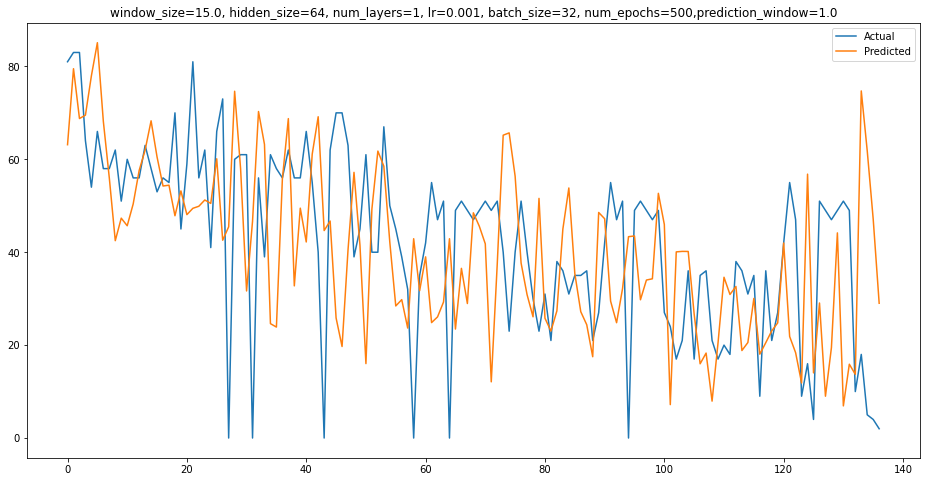

In [217]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size/2}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window/2}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [218]:
# test loss on MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(y_test_1, predictions_1))
print("Mean Squared Error: ", mean_squared_error(y_test_1, predictions_1))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test_1, predictions_1)))

Mean Absolute Error:  17.35074398291372
Mean Squared Error:  488.7295350681273
Root Mean Squared Error:  22.107228118154644
